<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Data-Loading-from-prepared-CSV-files" data-toc-modified-id="Imports-and-Data-Loading-from-prepared-CSV-files-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Data Loading from prepared CSV files</a></span></li><li><span><a href="#GroupedDFCollection-Class" data-toc-modified-id="GroupedDFCollection-Class-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>GroupedDFCollection Class</a></span></li><li><span><a href="#Visual-Analysis-and-Grouped-Composites" data-toc-modified-id="Visual-Analysis-and-Grouped-Composites-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visual Analysis and Grouped Composites</a></span></li><li><span><a href="#KMeans" data-toc-modified-id="KMeans-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>KMeans</a></span></li><li><span><a href="#Correlation-Analysis" data-toc-modified-id="Correlation-Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Correlation Analysis</a></span></li><li><span><a href="#Data-Export" data-toc-modified-id="Data-Export-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Data Export</a></span></li></ul></div>

**DESCRIPTION**

In this notebook I will try to select main tickers or its composites which could efficiently play role as representatives in its groups or clusters. It is one of main part of the project. The reason of doing such research is that training predictive models for all ~7000 companies seems unreasonable and impossible.  
On the step 6 (recurrent neural nertworks) I will test some of clusters created here on closeness in terms of model forecast quality. In other words, I will fit model on cluster center and run forecast on other random companies from selected cluster and evaluate r2 score.

**Main Steps and proposed Approaches**

- (1) Defining clusters by categorical features
  - features: Sector, Industry, Exchange
  - representative center: averaged time series (Composites) within groups
  - for averaging Median used, since it makes less informational impact from group comparing to MEAN


- (2) Identifying clusters by KMeans++ algorithm
  - dataset for clusterization - PCT-prices


- (3) Correlation Clusterization (experimental approach)
  - clusters defined by groups with companies related to each other with threshold level of positive correlation
  - parameters:
    - threshold correlation level - 0.65
    - maximum number of clusters - 20
  - cluster centers - defined as centers of Graph (created by group)
 
This part of code contains detailed research with a lot of visualization and comments.  

**Functions from project_lib**
- `create_grouped_df_adv` - generate grouped DataFrame by given col-name and dictionary with group names as keys and list of companies within a group as values


- `change_categorical_value` - replace categorical values in `old_values` with `new_name` in given `col` of `df`


- `collect_corr_tickers` - generate collection of clusters (as DICT) based on correlation matrix and threshold. It is quote complex function. See details of steps in function annotation


- `clean_cluster_collection` - calculate and return `cluster_collection` list of sets and `globe_set` based on given `correlated_features_filtered`, this function is used to drop out intersectections between clusters, which generated in result of `collect_corr_tickers` function


- `calculate_tickers_set` - calculate and return unique tickers in SET based on given `correlated_features_filtered` DICT


- `plot_cluster_coverage` - run looping process for given number of clusters range and plot results (see annotation for the details)


- `define_nodes_set` - same as `calculate_tickers_set` (but used in graph part)


- `create_graph_object` - create NetworkX Graph object with nodes and edges from given datasets


- `calculate_graph_centers` - calculate and collect to LIST centers of given Graph


- `plot_graph` - display graph with colored given centers


- `show_groups_dynamics_single_df` - plot cluster centers dynamics with borders (see annotation and `GroupedDFCollection.show_composites_dynamics` method for the details and `



**GroupedDFCollection Class**
- `GroupedDFCollection` - class which initialize instance object for calculation and compare statistics, visualizing initial df and grouped by clusters dfs. See class annotation for more details.
- It used only in this step and have a lot of methods, so I remained it here and didn't put it to function module in order to look it's code here without opening module-file


**Other Notes**
- Principally, this part is quite optional for the main purpose of the Project (comparing RNN and ARIMA for time series forecasting).
- However, the analysis and grouping of companies can be used, directly or indirectly, to create portfolios or comparisons of companies or to view general trends when detailed information is not available.
- All resulting object (DICTS and DATAFRAMES) saved to `datasets_4_modelling` folder
  - in order to safety - I will commented those part

### Imports and Data Loading from prepared CSV files

In [1]:
# 1.1 necessary modules
import numpy as np
import pandas as pd
import os
import csv
from pprint import pprint
import time
import warnings
from datetime import date as dt
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score, silhouette_score
import networkx as nx
from itertools import product
import operator
import pickle

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# 1.2. Importing classes and functions from project_lib

# functions for composite analysis
from project_lib import create_grouped_df_adv, change_categorical_value

# functions for defining correlated clusters
from project_lib import clean_cluster_collection, calculate_tickers_set
from project_lib import collect_corr_tickers, plot_cluster_coverage

# functions for graph construction
from project_lib import define_nodes_set, create_graph_object, plot_graph
from project_lib import calculate_graph_centers, show_groups_dynamics_single_df

In [3]:
# 1.3. Datasets loading

# Company profiles
with open('datasets/df_profiles_cleaned.csv', 'r', encoding='utf-8') as f:
    df_profiles = pd.read_csv(f, encoding='utf-8')

df_profiles = df_profiles.drop(columns=['Unnamed: 0'], axis=1)
print('company profiles')
display(df_profiles.head(3))


# Company stock prices net changes
with open('datasets/df_prices_margin_cleaned.csv', 'r', encoding='utf-8') as f:
    df_prices_pct = pd.read_csv(f, encoding='utf-8')

df_prices_pct = df_prices_pct.set_index('date')
print('company price changes in percent')
display(df_prices_pct.head(3))

company profiles


,symbol,companyName,sector,industry,exchange,description,ceo,mktCap
0,TIPT,Tiptree Inc.,Financial Services,Insurance - Specialty,NASDAQ Capital Market,Tiptree Inc is focused on enhancing shareholde...,Jonathan Ilany,1.935506e+08
1,BPOST.BR,bpost SA/NV,Industrials,Integrated Freight & Logistics,Brussels,"bpost SA/NV, together with its subsidiaries, p...",NaN,1.376007e+09
2,BKN,BlackRock Investment Quality Municipal Trust I...,Financial Services,Asset Management,New York Stock Exchange,Blackrock Investment Quality Muni Tr is a dive...,John M. Perlowski,2.595071e+08


company price changes in percent


,AAA.AS,AAB.TO,AADR,AALB.AS,AAL,AAMC,AAME,AAN,AAOI,AAON,...,ZNH,ZN,ZSAN,ZSL,ZTR,ZTS,ZYNE,ZYXI,ZZZ.TO,Z
date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-0.000955,0.000000,0.000000,-0.001328,-0.009533,-0.004498,-0.055785,0.019400,-0.012891,-0.002257,...,0.008011,0.021858,0.055042,-0.017007,0.000826,0.015655,-0.043433,0.108108,0.000587,-0.005427
2016-01-06,0.003185,0.076923,-0.015115,-0.022599,0.017522,0.002510,0.028446,-0.075692,-0.001866,-0.018552,...,-0.002838,-0.026738,-0.032258,-0.003968,-0.009076,0.000208,-0.016216,0.073171,-0.009384,-0.001364
2016-01-07,-0.000635,0.000000,0.000000,-0.013941,-0.018918,-0.224837,-0.025532,-0.032756,-0.047352,-0.022130,...,-0.045830,-0.010989,0.004115,-0.040000,-0.011657,-0.030404,-0.038462,-0.068182,-0.023091,-0.020947


Only 2 datasets loaded and will be used here
- `df_profiles_cleaned.csv` - companies profiles
- `df_prices_margin_cleaned.csv` - NetMarginPrices

### GroupedDFCollection Class

In [4]:
class GroupedDFCollection:
    """
    class which initialize instance object for calculation and compare statistics, visualizing initial df and grouped by clusters dfs
    
    Initialisation params
    -------------------------------------------------------------
    `df_profiles`: dataframe with company profiles
    `df_prices`: dataframe with price or NetPriceMargin time series
    `gdf`: dataframe with companies grouped to clusters
    
    Created attribute-objects at initialization:
    -------------------------------------------------------------
    `df_coll`: dictionary with sliced dataframes for each group
    `composites`: dict with averaged by MEDIAN per group prices
    `df_composites`: same object as `composites` but in form of 
    single dataframe
    
    Methods for visualization:
    -------------------------------------------------------------
    `show_kde_plots_for_composites` - plot KDE-charts for all 
    composites in one plot;
    
    `show_composites_dynamics` - plot all composites dynamics 
    rescaled by `period`:'D'-daily, 'MS'-monthly, 'AS'-annualy
    and with optional bool param `plot_std`, which add second
    plot with STD for composites;
    
    `calc_avg_stats_all_groups` - calculates averaged statistics
    for all companies in group, which afterwards averaged for 
    timeline and returns results as dataframe for all groups
    optional bool param: `show_table` - displays returned df;
    
    `show_groups_dynamics` - plot composite dynamics and borders 
    for selected `composite` (STR) with rescaled timeline with
    following arguments:
       - `composite`: name of composite, must correspond to 
         created composites in Instance (self.composites)
       - `period` - rescaling parameter (D, MS or AS)
       - `borders` - stat.borders added to plot with options:
         - None - no borders added
         - `q25-q75` - borders defined as q25-q75
         - `min-max` - borders defined as min and max values
         - `sigma` - borders defined as `sigma_coef`xSTD
       - `sigma_coef` (FLOAT) - used for sigma-borders
    """
    
    def __init__(self, df_profiles, gdf, df_prices):
        self.df_profiles = df_profiles
        self.gdf = gdf
        self.df_prices = df_prices
        try:
            self.df_coll = self._create_df_coll_by_gdf()
        except Exception:
            self.df_coll = None
        self.composites = self._created_composites()
        self.df_composites = self._merge_all_composites()    
           
    def _create_df_coll_by_gdf(self):
        sliced_df_dict = dict()
        col_name = self.gdf.index.name
        for group in self.gdf.index:
            sliced_df = self.df_profiles.loc[self.df_profiles[col_name]==group]
            symbol_list = sliced_df.symbol.to_list()
            sliced_df = self.df_prices.T.loc[symbol_list]
            sliced_df_dict[group] = sliced_df
        return sliced_df_dict
    
    def _created_composites(self):
        composites_dict = dict()
        for group in self.df_coll.keys():
            df = self.df_coll[group]
            composite = pd.DataFrame(df.median(), columns=[group])
            composites_dict[group] = composite
        return composites_dict
    
    def _merge_all_composites(self):
        df_composites = pd.DataFrame([], columns=self.composites.keys())
        for group in df_composites.columns:
            df_composites[group] = self.composites[group][group]
        return df_composites
    
    
    def show_kde_plots_for_composites(self):
        plt.figure(figsize=(16,5))
        plt.title(f'composite KDE for df grouped by {self.gdf.index.name}')
        for group in self.df_composites.columns:
            array = np.array(self.df_composites[group])
            sns.distplot(array, label = group)
        plt.legend()
        plt.show()
            
    def _calc_stat_report_in_group(self, group):
        grouped_df = self.df_coll[group]
        stats_avg_per_comps = grouped_df.describe()
        stats_median_allperiods = pd.DataFrame(stats_avg_per_comps.T.median(), columns=[group])
        return stats_median_allperiods
    
    def calc_avg_stats_all_groups(self, show_table=False):
        stats_df = pd.DataFrame([], columns=[g for g in self.df_coll.keys()])
        for group in stats_df.columns:
            stats_df[group] = self._calc_stat_report_in_group(group)[group]
        if show_table:
            display(stats_df)
        return stats_df
    
    def show_composites_dynamics(self, period, plot_std=True):
        df_4_chart = self.df_composites.set_index(pd.to_datetime(self.df_composites.index, format='%Y-%m-%d'))
        if period in ['D', 'MS', 'AS']:
            df_4_chart = df_4_chart.resample(period).mean()
            if plot_std:
                fig,ax  = plt.subplots(2,1, figsize=(16,9))
                ax[0].title.set_text(f'composite dynamics for df grouped by {self.gdf.index.name}')
                ax[1].title.set_text('standart deviation in group')
                sns.lineplot(data=df_4_chart, ax=ax[0], dashes='')
                data2 = self.calc_avg_stats_all_groups()
                sns.barplot(data=data2.loc[data2.index=='std'], ax=ax[1], orient='h')
                plt.tight_layout()
                plt.show()
            else:
                plt.figure(figsize=(16,6))
                plt.title(f'composite dynamics for df grouped by {self.gdf.index.name}')
                ax = sns.lineplot(data=df_4_chart, dashes='')
                plt.tight_layout()
                plt.show()
        else:
            print('arguments for period must be {D, MS or AS}')
        
    
    def show_groups_dynamics(self, composite, period='AS',  borders='q25-q75', sigma_coef=1):
        
        timestamp = pd.to_datetime(self.df_composites.index, format='%Y-%m-%d')
        df_comps = self.df_coll[composite].T.set_index(timestamp)
        df_composite = pd.DataFrame(self.df_composites[composite], columns=[composite])
        df_composite = df_composite.set_index(timestamp)
        df_comps = df_comps.resample(period).mean()
        df_composite = df_composite.resample(period).mean()
        stat_data = df_comps.T.describe().T
        
        fig = plt.figure(figsize=(15,4))
        sns.lineplot(data=df_composite, c='orange', linewidth=1.2)
        title_ending=''
        if borders:
            border_min, border_max = stat_data['min'], stat_data['max']
            border_q25, border_q75 = stat_data['25%'], stat_data['75%']
            border_minus_Xsigma = stat_data['mean'] - sigma_coef*stat_data['std'] 
            border_plus_Xsigma = stat_data['mean'] + sigma_coef*stat_data['std']
            if borders == 'min-max':
                border_low, border_high = border_min, border_max
            elif borders == 'sigma':
                border_low, border_high = border_minus_Xsigma, border_plus_Xsigma
            elif borders == 'q25-q75':
                border_low, border_high = border_q25, border_q75
            sns.lineplot(data=border_low, c='r', linewidth=0.3, style='-')
            sns.lineplot(data=border_high, c='green', linewidth=0.3)
            plt.fill_between(df_composite.index, border_low.values, 
                             border_high.values, alpha=0.1, color='green')
            title_ending = f' with borders {borders}'
        
        plt.legend()
        plt.title(f'{composite} composite dynamics p.{period[0].lower()}{title_ending}')
        plt.show()
        



### Visual Analysis and Grouped Composites

This part contains calculation and visual analysis of composites, calculated on clusters grouped by different categorical values

In [5]:
# 3.1 Creating Lists of companies, grouped by PARAMS

df_profiles_cleaned = df_profiles[['sector','symbol', 'industry', 'exchange', 'mktCap']]

gdf_sector, names_per_sector = create_grouped_df_adv('sector', df_profiles_cleaned, agg_func=np.count_nonzero)

gdf_industry, names_per_industry = create_grouped_df_adv('industry', df_profiles_cleaned, agg_func=np.count_nonzero)

gdf_exchange, names_per_exchange = create_grouped_df_adv('exchange', df_profiles_cleaned, agg_func=np.count_nonzero)

In [6]:
# 3.2. Visual analysis for grouped dataframes

for title, gdf in zip(['sector', 'industry', 'exchange'], 
                      [names_per_sector, names_per_industry, names_per_exchange]):
    print(f'for {title} param {len(gdf)} groups formed with {len(df_profiles_cleaned)/len(gdf):.0f} average comps per group')

for sector param 14 groups formed with 493 average comps per group
for industry param 223 groups formed with 31 average comps per group
for exchange param 19 groups formed with 363 average comps per group


Using industry as a parameter for grouping generate too big number of groups (223), hence only Sector and Exchange features will be used in  further steps

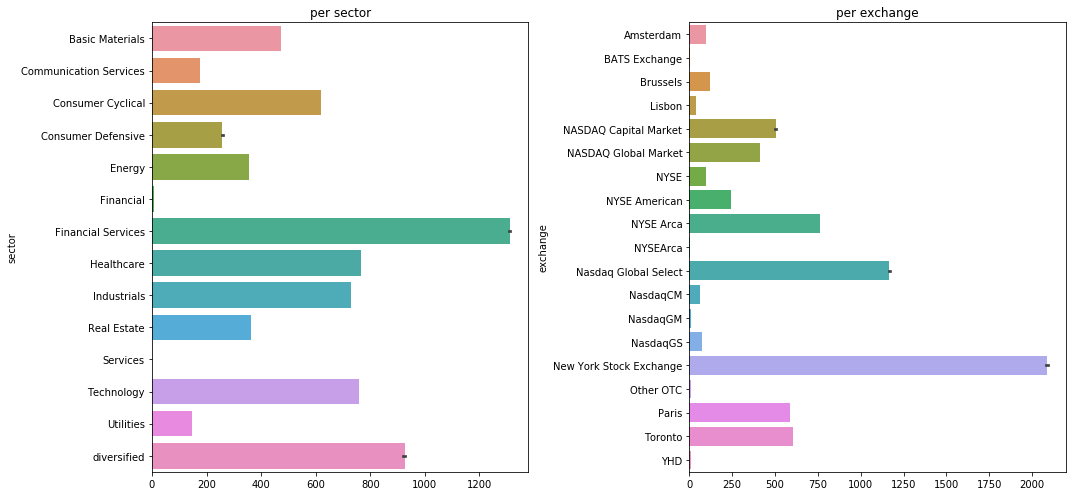

In [7]:
# 3.3. Visual analysis for grouped dataframes before adjustments

fig, ax = plt.subplots(1,2,figsize=(15,7))

ax[0].set_title('per sector')
ax[1].set_title('per exchange')
sns.barplot(data=gdf_sector.T, orient='h', ax=ax[0])
sns.barplot(data=gdf_exchange.T, orient='h', ax=ax[1])
plt.tight_layout()
plt.show()

There are groups with extremely small numbers of companies. It could be due to originial data allocation or some mistakes. The following adjustments are proposed:
- merge similar exchanges (similarity defined by name or geolocation)
- merge similar sectors.  
Here, I used my subjective opinion of how define similarity, so it is only one of possible adjustments here.

for symbol param 12 groups formed with 575 average comps per group
for exchange param 4 groups formed with 1724 average comps per group


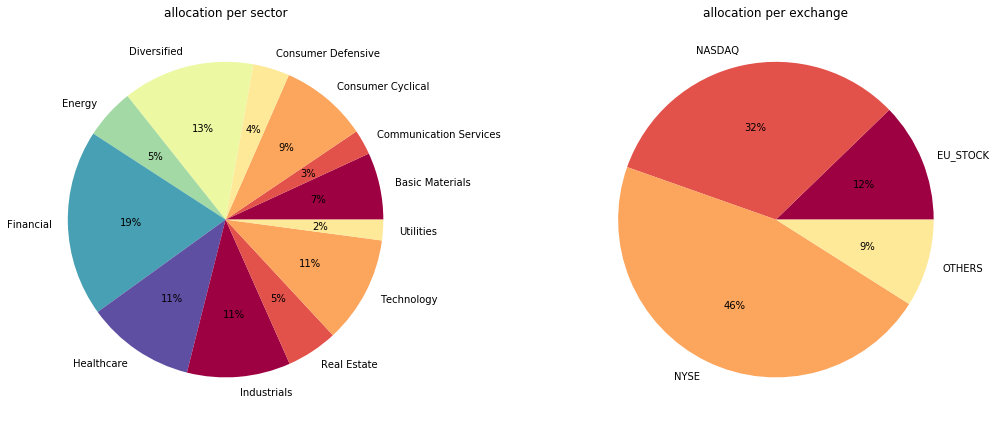

In [8]:
# 3.4. Adjusting profiles dataframe, redefiing grouped Dataframes  and Visual analysis

NYSE = ['NYSE', 'NYSE American', 'NYSE Arca', 'NYSEArca',  'New York Stock Exchange']
NASDAQ = ['NASDAQ Capital Market', 'NASDAQ Global Market', 'Nasdaq Global Select', 'NasdaqCM',
         'NasdaqGM', 'NasdaqGS']
EU_STOCK = ['Amsterdam', 'Lisbon','Paris', 'Brussels']
OTHERS = ['BATS Exchange', 'Other OTC', 'Toronto', 'YHD']

FINANCIAL = ['Financial Services', 'Financial']
DIVERS = ['diversified', 'Services']

try: # added because once it done, repeated code running raise Exception
    for old_values, new_name in zip([NYSE, NASDAQ, EU_STOCK, OTHERS],
                                    ['NYSE', 'NASDAQ', 'EU_STOCK', 'OTHERS']):
        
        df_profiles_cleaned = change_categorical_value(df_profiles_cleaned, new_name, old_values, 'exchange')

    for old_values, new_name in zip([FINANCIAL, DIVERS], ['Financial', 'Diversified']):
        df_profiles_cleaned = change_categorical_value(df_profiles_cleaned, new_name, old_values, 'sector')

    for col_name in ['sector', 'industry', 'exchange']:
        df_profiles_cleaned[col_name] = df_profiles_cleaned[col_name].astype('category')
except Exception:
    print('operations already done!')   
    
gdf_sector, names_per_sector = create_grouped_df_adv('sector', df_profiles_cleaned, agg_func=np.count_nonzero)
gdf_exchange, names_per_exchange = create_grouped_df_adv('exchange', df_profiles_cleaned, agg_func=np.count_nonzero)

for title, gdf in zip(['symbol', 'exchange'], 
                      [names_per_sector, names_per_exchange]):
    print(f'for {title} param {len(gdf)} groups formed with {len(df_profiles_cleaned)/len(gdf):.0f} average comps per group')
    
fig, ax = plt.subplots(1,2,figsize=(15,6))
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]

ax[0].set_title('allocation per sector')
ax[1].set_title('allocation per exchange')

ax[0].pie([len(i) for i in names_per_sector.values()], labels=names_per_sector.keys(), 
          autopct='%1.0f%%', colors=colors)
ax[1].pie([len(i) for i in names_per_exchange.values()], labels=names_per_exchange.keys(), 
          autopct='%1.0f%%', colors=colors)

plt.tight_layout()
plt.show()

2 possible sets of clusters were formed by grouping approach:
- clusters defined by Sector - 12
- clusters defined by Exchange - 4

Let's look on its visualization.

In [9]:
# 3.5. Composites statistics for both Cluster-types
cluster_per_sector = GroupedDFCollection(df_profiles_cleaned, gdf_sector, df_prices_pct)
cluster_per_exchange = GroupedDFCollection(df_profiles_cleaned, gdf_exchange, df_prices_pct)

cluster_per_sector.calc_avg_stats_all_groups(show_table=True)
cluster_per_exchange.calc_avg_stats_all_groups(show_table=False)

,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Diversified,Energy,Financial,Healthcare,Industrials,Real Estate,Technology,Utilities
count,474.000000,177.000000,618.000000,259.000000,930.000000,355.000000,1317.000000,765.000000,730.000000,362.000000,757.000000,146.000000
mean,0.000914,0.000739,0.000769,0.000794,0.002941,-0.000135,0.002110,0.002876,0.001257,0.000856,0.002317,0.000820
std,0.036481,0.028903,0.029601,0.026295,0.035528,0.032867,0.022266,0.048422,0.030724,0.019527,0.035885,0.018238
min,-0.192156,-0.122816,-0.200000,-0.121951,-0.238062,-0.166667,-0.234901,-0.322307,-0.215054,-0.114911,-0.250000,-0.075472
25%,-0.011025,-0.007104,-0.008107,-0.006749,-0.002323,-0.010638,-0.004058,-0.013423,-0.007245,-0.003997,-0.007827,-0.004327
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000070
75%,0.010872,0.007087,0.008743,0.006888,0.003063,0.008776,0.004854,0.012390,0.007631,0.005381,0.009161,0.005851
max,0.250000,0.154416,0.244119,0.145562,0.320167,0.218967,0.304000,0.470744,0.290845,0.139830,0.333333,0.082128


,EU_STOCK,NASDAQ,NYSE,OTHERS
count,842.000000,2230.000000,3198.000000,620.000000
mean,0.001043,0.003170,0.005294,0.000783
std,0.035198,0.042883,0.034988,0.036533
min,-0.333333,-0.425935,-0.485838,-0.229968
25%,-0.004839,-0.009294,-0.005134,-0.007421
50%,0.000000,0.000000,0.000000,0.000000
75%,0.005016,0.009635,0.005803,0.007214
max,0.439209,0.902848,0.883929,0.323077


In general, the tables above show that averaged versions of NetPriceMargin per cluster are similar to each other with center ~ 0 and with symmetrical shape.

Based on averaged stats it is hard to say, how clusters different. Let's look on visual information.

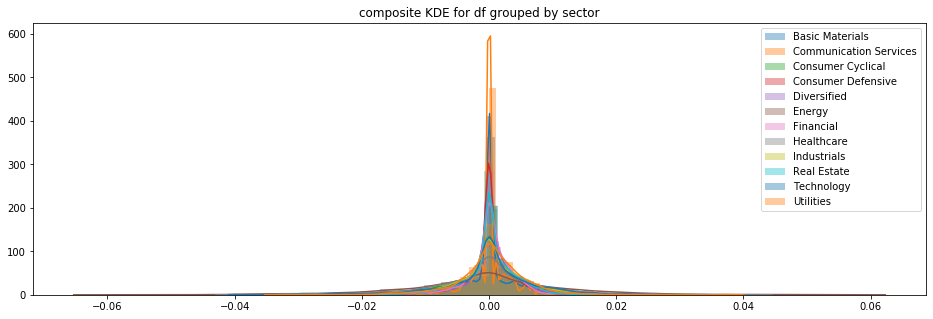

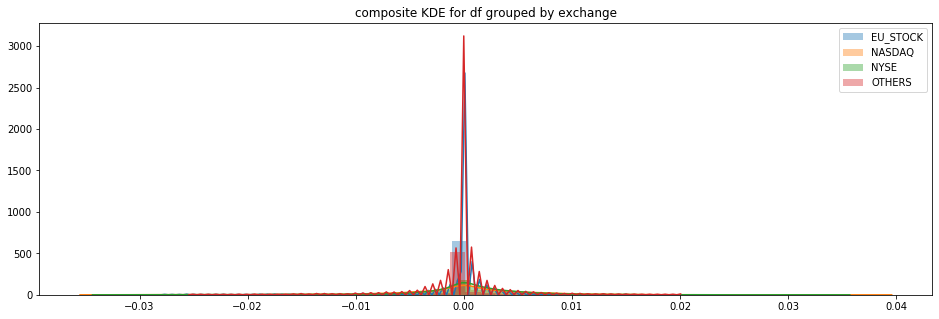

In [10]:
# 3.6. KDE visualization
cluster_per_sector.show_kde_plots_for_composites()
cluster_per_exchange.show_kde_plots_for_composites()

Unfortunately, KDE plots don't provide sufficient information to our question except that different clusters has different VAR.    
Let's look on dynamics of composites (composite - defined as MEDIAN in cluster) for each cluster.  

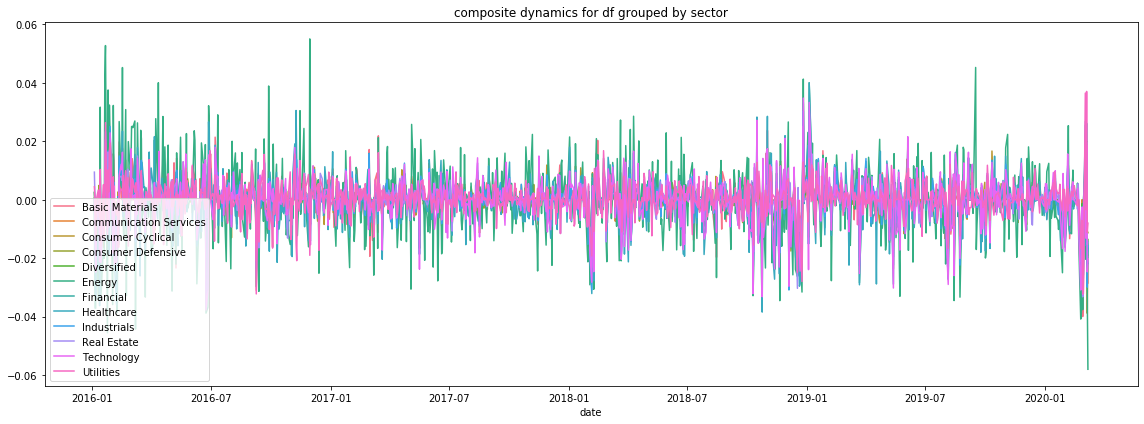

In [11]:
# 3.7. Daily composite dynamics
cluster_per_sector.show_composites_dynamics(period='D', plot_std=False)

Daily quotes are have redundant details and don't provide useful information.  

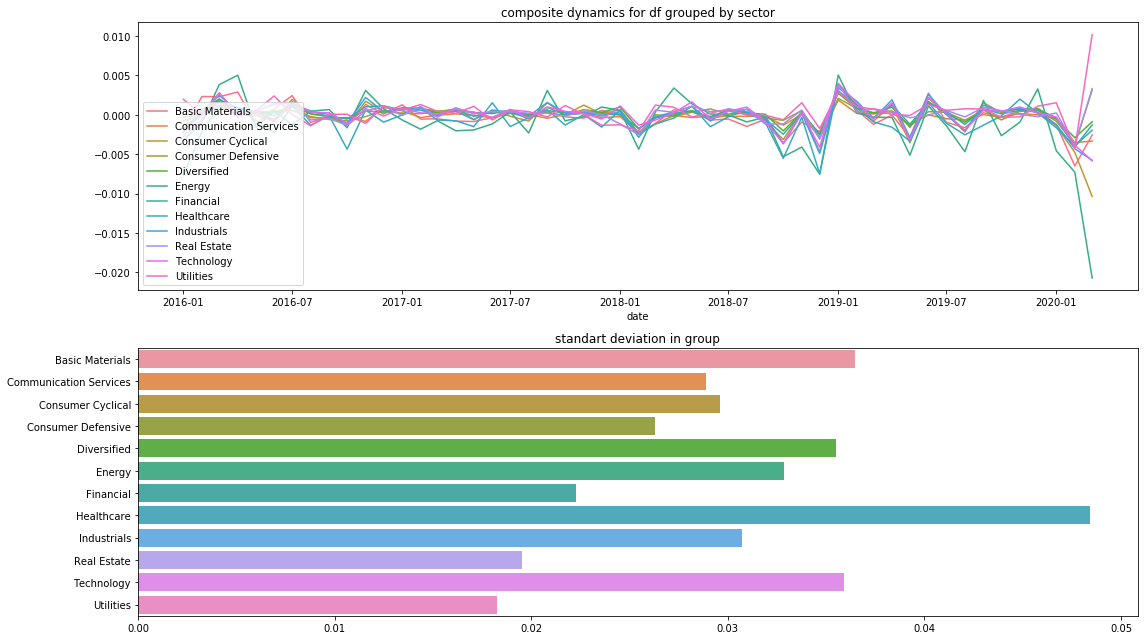

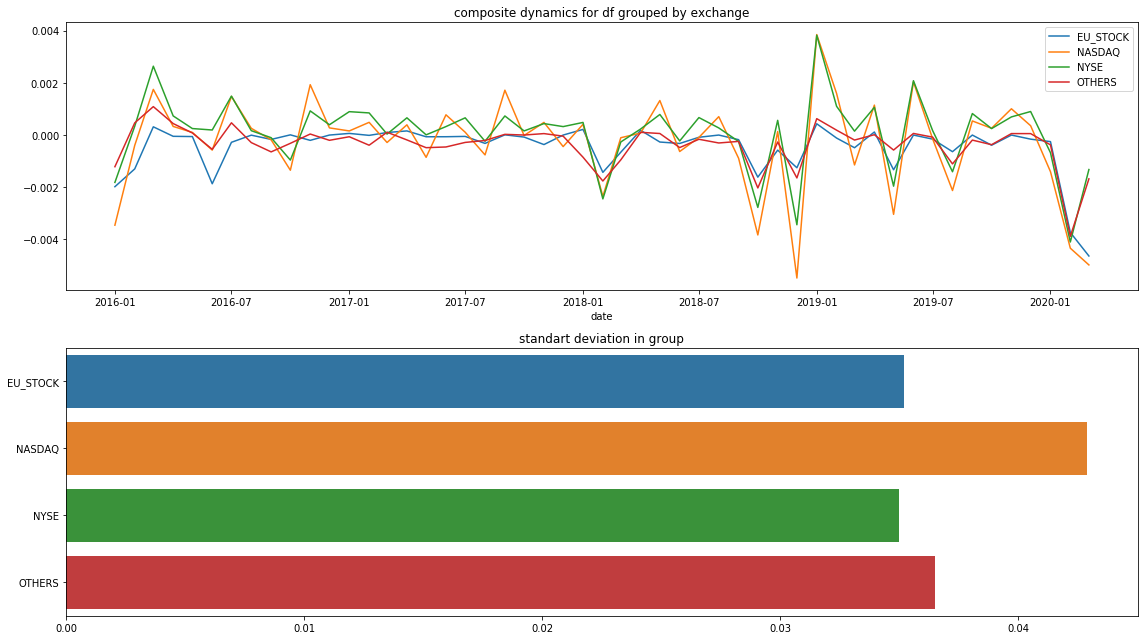

In [12]:
# 3.8. Monthly averaged composite dynamics for both types
cluster_per_sector.show_composites_dynamics(period='MS', plot_std=True)
cluster_per_exchange.show_composites_dynamics(period='MS', plot_std=True)

Composites averaged per month are better show some tendency. In particular, it can be seen, that:
- sector clusters are more homogeneous, and they have different VAR comparing to each other
- exchange clusters are more homogeneous and could be merged into 2 superclusters:
  - NYSE + NASDAQ
  - EU_STOCK + OTHERS

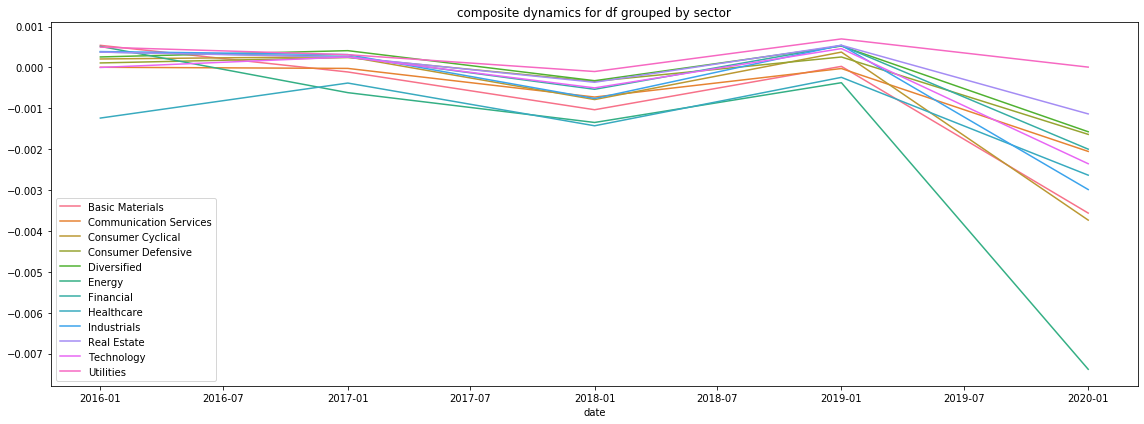

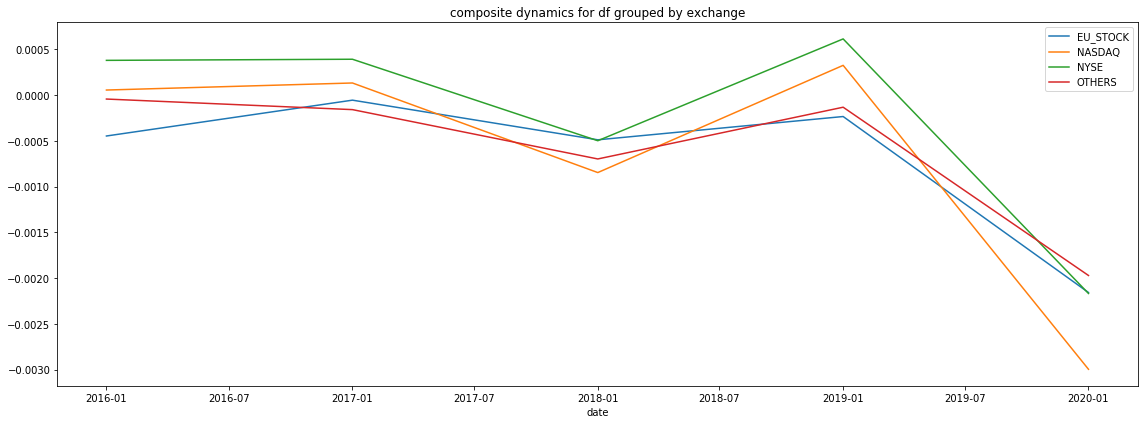

In [13]:
# 3.9. Annualy averaged composite dynamics for both types
cluster_per_sector.show_composites_dynamics(period='AS', plot_std=False)
cluster_per_exchange.show_composites_dynamics(period='AS', plot_std=False)

Averaging to year-basis strongly smooth details and shows global long-term trends, so it is not usefull for current Project.

On next steps let's look on detailed monthly averaged composite dynamics.

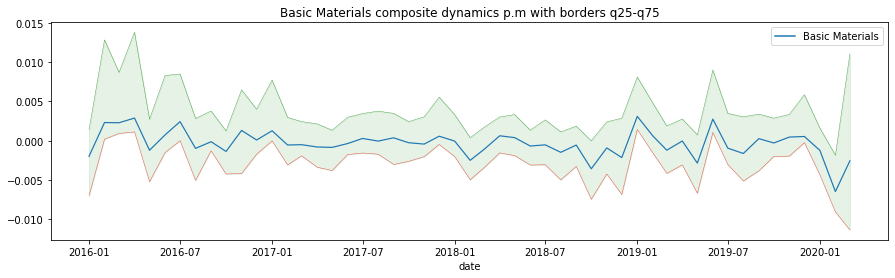

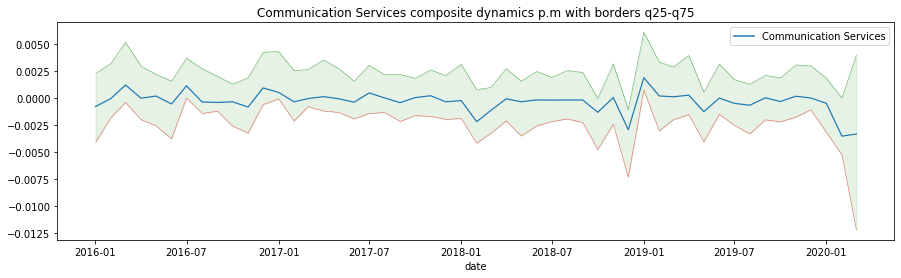

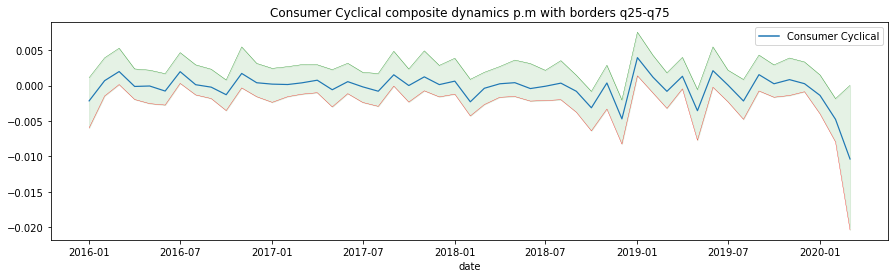

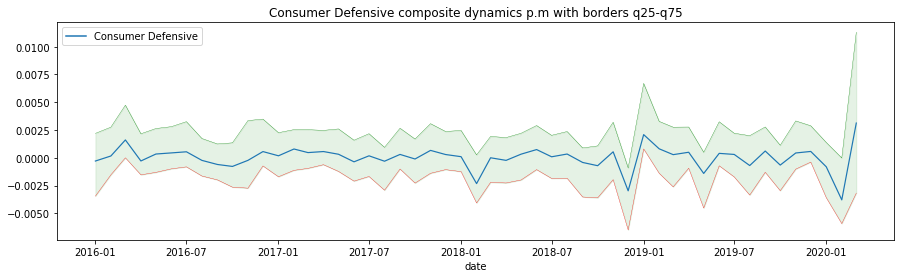

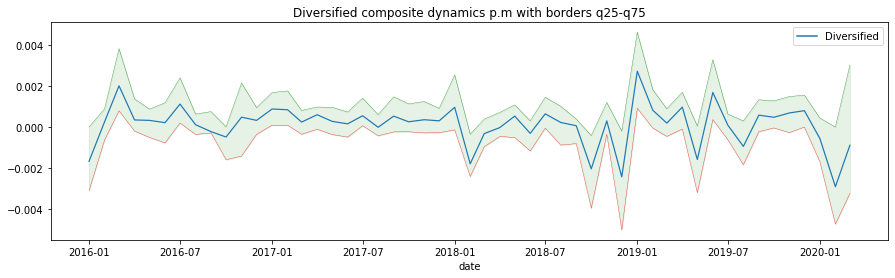

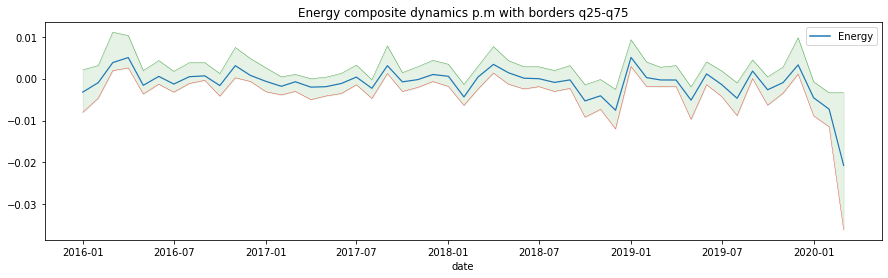

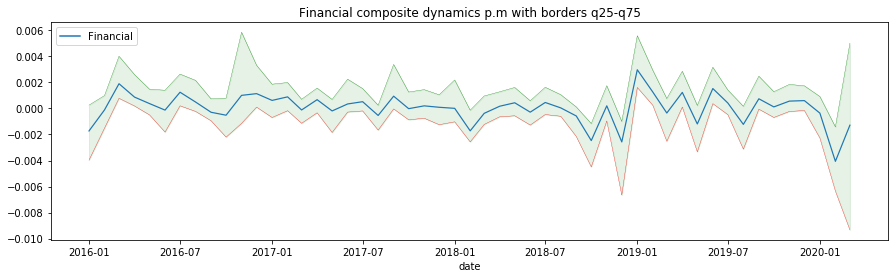

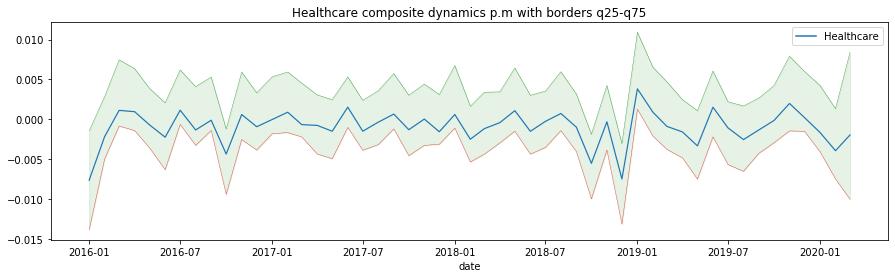

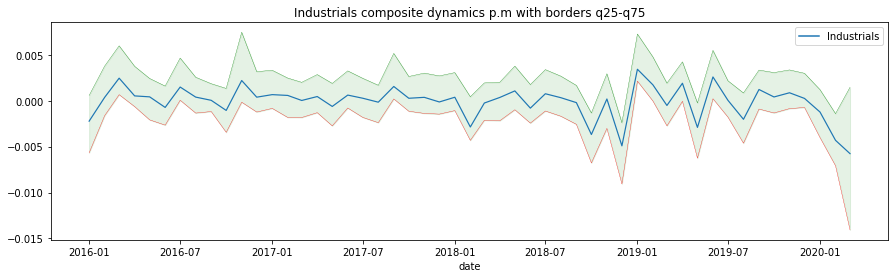

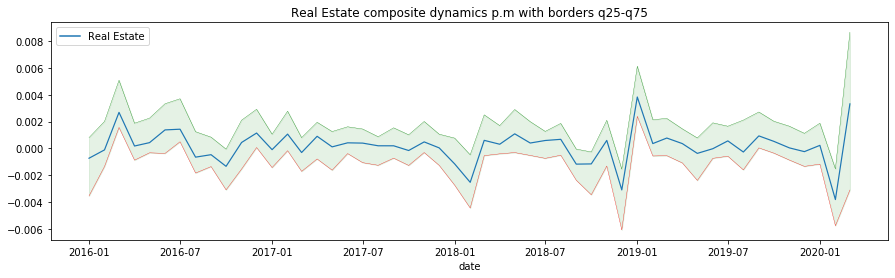

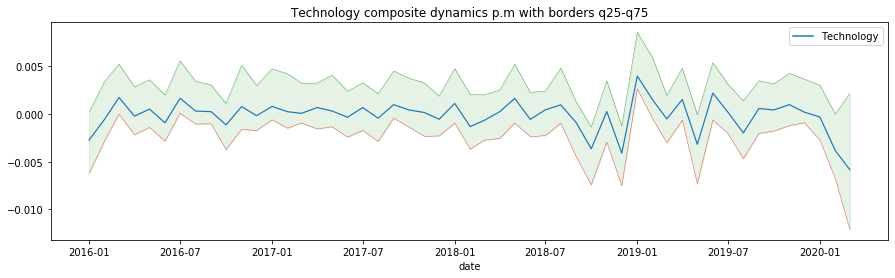

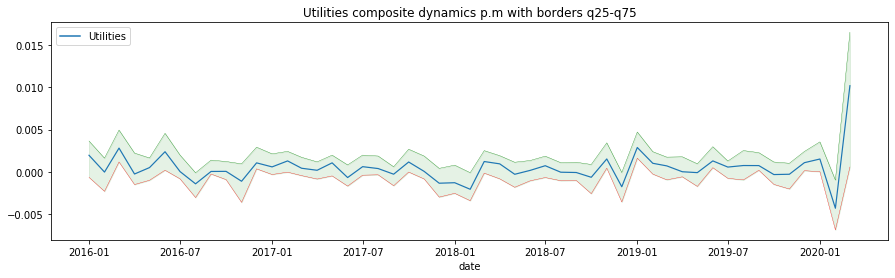

In [14]:
# 3.10. Detailed composite charts per sector (monthly averaged)
for group in cluster_per_sector.composites:
    cluster_per_sector.show_groups_dynamics(group, period='MS')

On the whole, q25-q75 borders repeat the dynamics of the composite index qualitatively enough, and borders gap is not wide except for: Base Materials, Communication, Healthcare, Technology.  

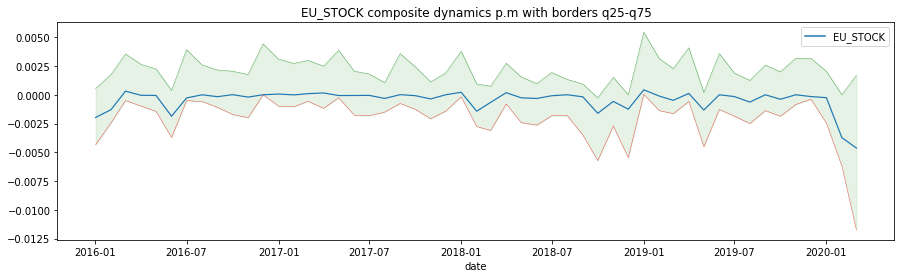

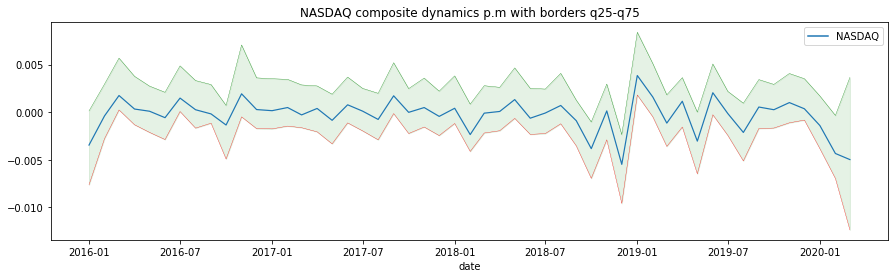

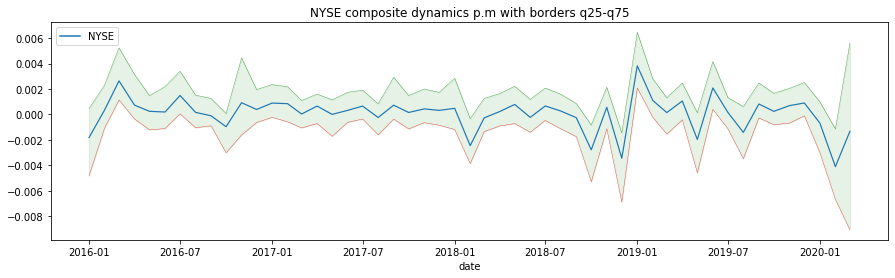

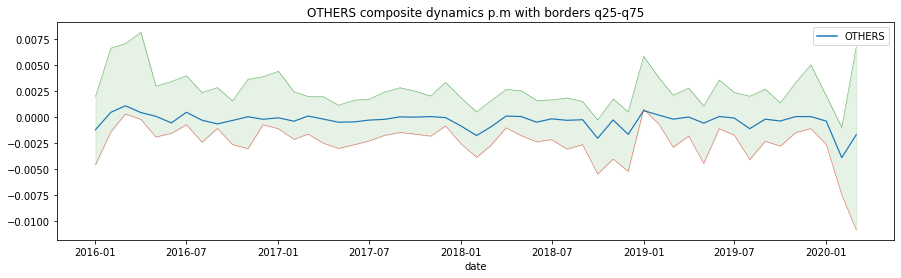

In [15]:
# 3.11. Detailed composite charts per exchange (monthly averaged)
for group in cluster_per_exchange.composites:
    cluster_per_exchange.show_groups_dynamics(group, period='MS')

In this cases we have poorer results:
- в OTHERS and EU_STOCK - composite badly correlated with borders
- In all clusters excluding NYSE - borders gaps are too wide

So, for the next steps it is recommended to use GROUPING by SECTOR for generating composites.

### KMeans

In this part I will run classical algorithm (KMeans) to identify possible clusters in Quotes

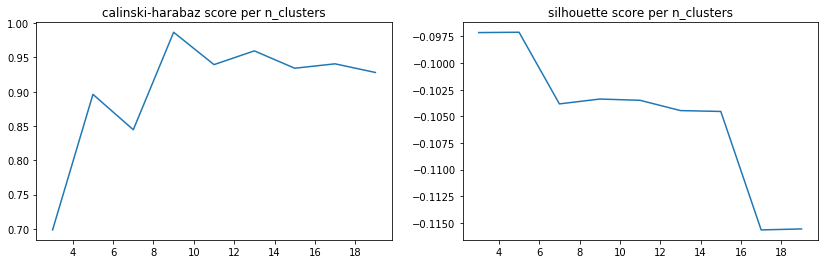

In [16]:
# 4.1. KMeans++
# attention: this cell can take up to 2 min

scaler = MinMaxScaler()
df_prices_pct_mms = scaler.fit_transform(df_prices_pct)

n_cluster_list, calinski_metric_list, silhouette_metric_list = [], [], []

for n_cluster in range(3,20,2):
    n_cluster_list.append(n_cluster)
    k_means = KMeans(n_clusters=n_cluster, random_state=42, init='k-means++', n_jobs=-1)
    k_means.fit(df_prices_pct)
    calinski_metric_list.append(calinski_harabaz_score(df_prices_pct_mms, k_means.labels_))
    silhouette_avg = silhouette_score(df_prices_pct_mms, k_means.labels_)
    silhouette_metric_list.append(silhouette_avg)

fig, ax = plt.subplots(1,2, figsize=(14,4))
ax[0].title.set_text('calinski-harabaz score per n_clusters')
ax[1].title.set_text('silhouette score per n_clusters')
ax[0].plot(n_cluster_list, calinski_metric_list)
ax[1].plot(n_cluster_list, silhouette_metric_list)
plt.show()

- Accoring to calinski harabaz score - optimal number of cluster is 9
- On the same time, silhouette score - is negative on the whole range, which tells us than in general clusterization here is not achievable.

### Correlation Analysis

Let's create correlation matrix based on NetPriceMargins

In [17]:
# 5.1. Creating correlation matrix from price margins
# attention: this cell can take up to 3 min

df_corr = df_prices_pct.corr()
print(df_corr.shape)

(6890, 6890)


Now, let's make corr-clustering with the following params:
- correlation threshold = 0.65
- number of clusters - not limited

Attentions: function used here (`collect_corr_tickers`, `calculate_tickers_set`, `clean_cluster_collection`) were written with standart Python functions and work relatively slow comparing to external lib functions.

In [18]:
# 5.2. First look on clusters
# attention: this cell can take up to 10 min

cff, stats_cff = collect_corr_tickers(df_corr, corr_threshold=0.65, n_cluster_limit=None, show_stats=True)
print(f'obtained clusters cover {100*calculate_tickers_set(cff)/len(df_corr):.1f}% of all dataset')

cff_cleaned, globe_set = clean_cluster_collection(cff, show_stats=True)

total number of identified clusters: 2293
biggest cluster size: 594
smallest cluster size: 2
median cluster size: 19
obtained clusters cover 33.3% of all dataset
after cleaning..
------------------------------
total inclusive clusters number: 634
biggest cluster contains 132 comps
smallest cluster contains 1 comps
average cluster's power 2 comps


So, defining clusters without limitation and without dropping dublicates (due to intersections between clusters) gives 2293 intersected clusters, which cover ~33% of all tickers set. Cluster sizes varies in big range: from 2 to 594 tickers. Intersection ratio ~ 96%.

After dropping dublicates (`clean_cluster_collection`):
- number of clusters reduced to 634

Let's visualize what `n_cluster_limit` could be efficient 

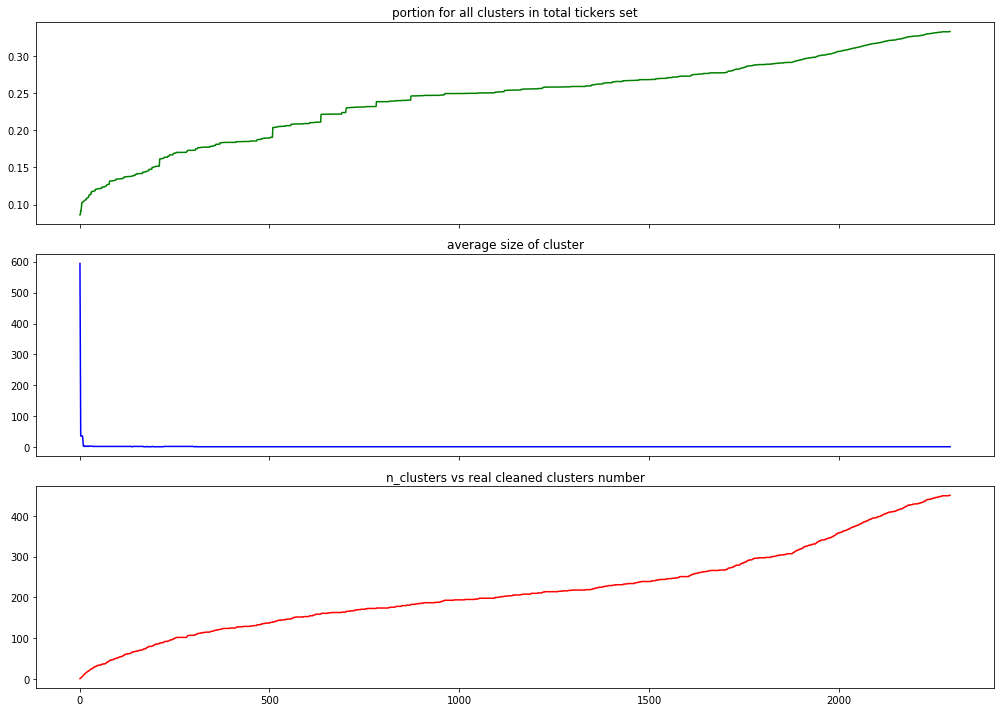

In [19]:
# 5.3. Visual analysis on cluster

plot_cluster_coverage(cff, stats_cff, df_corr,
                          start_step=1, end_step=None, step_in_range=1)

As seen from plots, dublicates dropping is strongly reduce number of clusters (approximately to 0.3), but on the same time average size of cluster also reduced sharply. It happens due to the fact that most of clusters are represented by very small-size clusters, which we can cut out on next steps.

In general, correlation approach for cluster identifying can't be compared to groupby approach in terms of tickers coverage, however could be more beneficial for some part of datasets when we need to define more robust composite ticker for the group. So, let's continue such analysis with `n_cluster_limit` = 200

In [20]:
# 5.4. Calculate clusters for 200 raw clusters
# attention: this cell can take up to 10 min

cff_200, stats_cff_200 = collect_corr_tickers(df_corr, corr_threshold=0.65, n_cluster_limit=200, show_stats=True)

print(f'200 uncleaned clusters cover {100*calculate_tickers_set(cff_200)/len(df_corr):.1f}% of all dataset')

cff_cleaned, globe_set = clean_cluster_collection(cff_200, show_stats=True)

total number of identified clusters: 200
biggest cluster size: 594
smallest cluster size: 293
median cluster size: 410
200 uncleaned clusters cover 15.1% of all dataset
after cleaning..
------------------------------
total inclusive clusters number: 85
biggest cluster contains 594 comps
smallest cluster contains 1 comps
average cluster's power 2 comps


In [21]:
# 5.5. Reducing cleaned clusters set
threshold = 10 # minimum number of comps in a cluster
total_comps = len(df_corr)

cff_cleaned_reduced = []
globe_set_reduced = set()

for i in cff_cleaned:
    if len(i)>=threshold:
        cff_cleaned_reduced.append(i)
        globe_set_reduced.update(i)
        

print(f'number of clusters was reduced to {len(cff_cleaned_reduced)}')
print(f'total number of companies in clusters: {len(globe_set_reduced)} of {len(globe_set)}')
print(f'average cluster size: {len(globe_set_reduced) / len(cff_cleaned_reduced):.0f}')
print(f'coverage ratio {100*len(globe_set_reduced) / total_comps:.0f}% of total dataset')

number of clusters was reduced to 14
total number of companies in clusters: 856 of 1042
average cluster size: 61
coverage ratio 12% of total dataset


So, finally 14 clusters were builded which covers 856 companies or 12% of the whole dataset.  
Average cluster size is 61 companies.  

On next stage I will generate Graph object to identify center (based on connected edges number).  
Those centers will be used as composite analogues.

In [22]:
# 5.6. Reorganizing obtained sets to initial dict form

data_4_graphs = []

for subset in cff_cleaned_reduced:
    cff_200_reduced = dict()
    for comp in subset:
        similar_comps = []
        for row in df_corr[comp].index:
            if row in df_corr[comp].index and 0.65 <= df_corr.loc[row, comp] < 1: # only positive corr taken to account
                similar_comps.append(row)
        if similar_comps != []:
            cff_200_reduced[comp] = similar_comps
    data_4_graphs.append(cff_200_reduced)
    
print(f'created {len(data_4_graphs)} dicts for further steps')

created 14 dicts for further steps


Let's looks how graph works on single small cluster before we will run it on all clusters.

0 unconnected nodes removed
1 clusters identified
center of the graph: ['FXL']


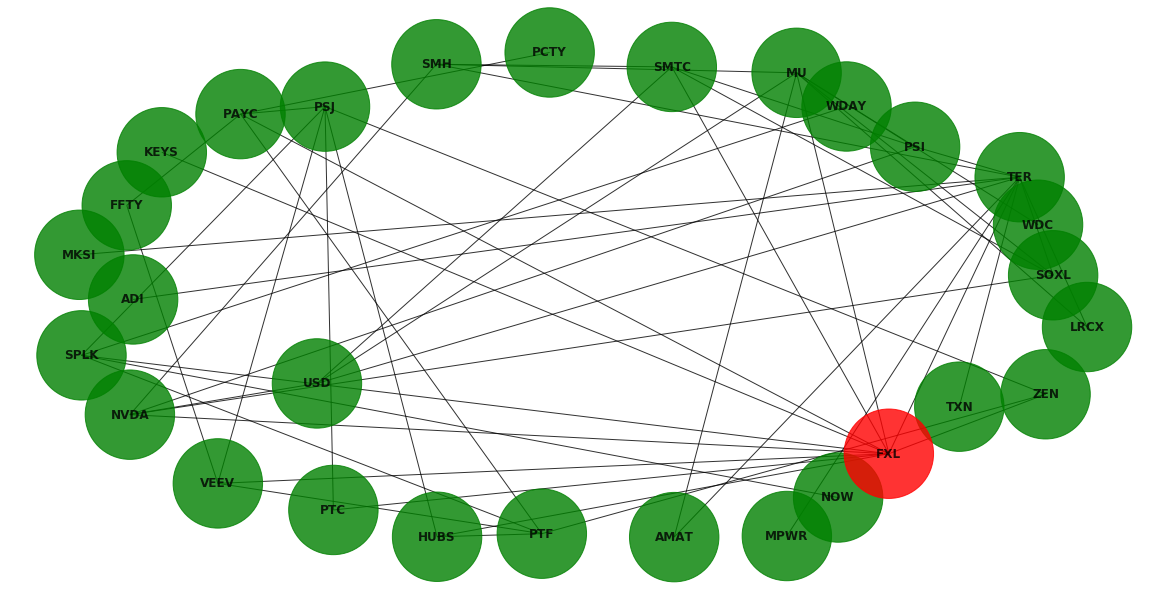

In [23]:
# 5.7. Testing Graph building 
example_cluster = data_4_graphs[-3]
G = create_graph_object(define_nodes_set(example_cluster), example_cluster)
centers = calculate_graph_centers(G, verbose=True)
print(f'center of the graph: {centers}')
plot_graph(G, centers, figsize=(16,8))

For given cluster 1 center identified (colored by red).  
In general, it is possible that several centers could be revealed, and in this case random center will be selected.

In [24]:
# 5.8. Identifying center nodes for all clusters

cluster_dict = dict()
for idx, cluster in enumerate(data_4_graphs):
    G = create_graph_object(define_nodes_set(cluster), cluster)
    center = calculate_graph_centers(G)
    if len(center) == 0:
        continue
    elif len(center) == 1:
        center = center[0]
    else:
        center = center[np.random.randint(len(center))]
    cluster_dict[center] = define_nodes_set(cluster)-{center}

In [25]:
# 5.9. Converting cluster results to collection of df

center_tickers = list(cluster_dict.keys())
df_prices_pct_centers = df_prices_pct[center_tickers]

df_profiles_clustered_collection = dict()
for key, value in cluster_dict.items():
    df = df_prices_pct[list(value)]
    df_profiles_clustered_collection[key] = df

 monthly price margin dynamics for MVV
----------------------------------------------------------------------------------------------------


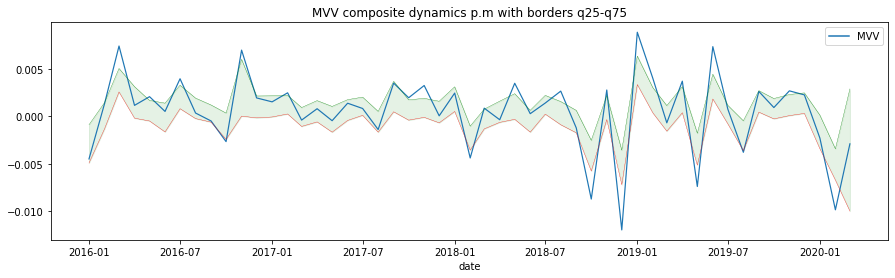

 monthly price margin dynamics for VBR
----------------------------------------------------------------------------------------------------


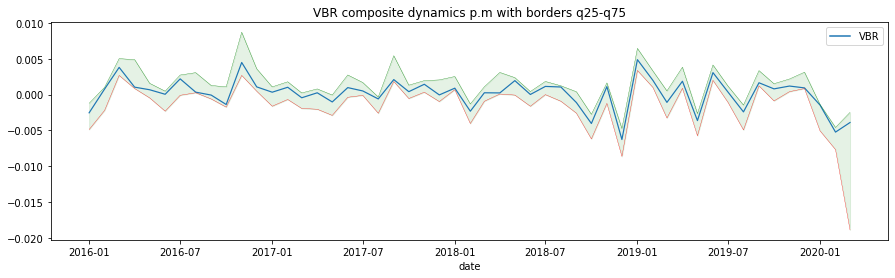

 monthly price margin dynamics for VOE
----------------------------------------------------------------------------------------------------


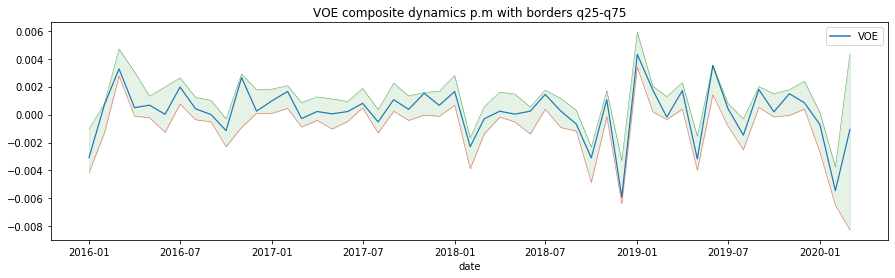

 monthly price margin dynamics for FEX
----------------------------------------------------------------------------------------------------


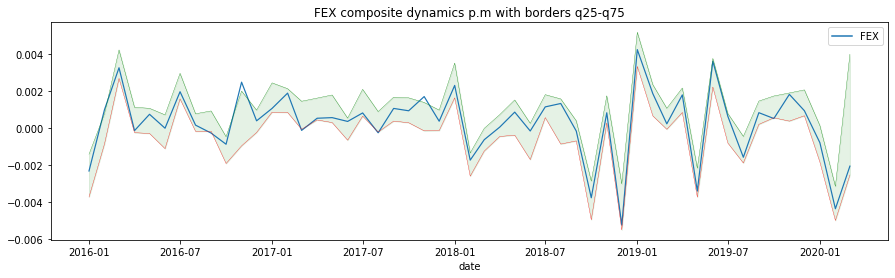

 monthly price margin dynamics for FXO
----------------------------------------------------------------------------------------------------


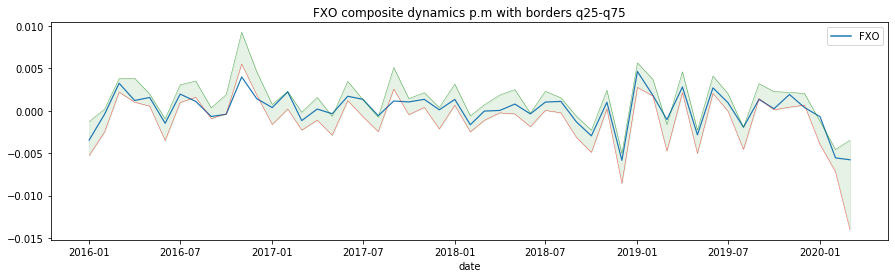

 monthly price margin dynamics for FXR
----------------------------------------------------------------------------------------------------


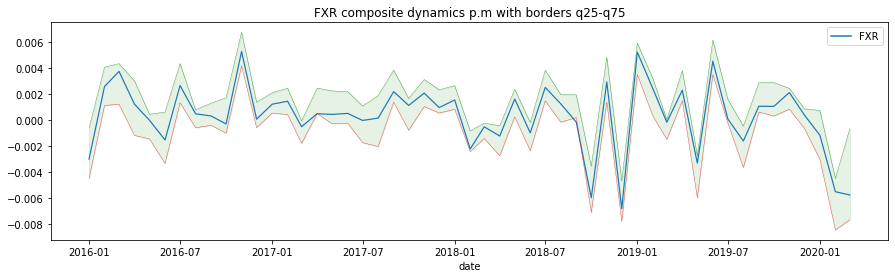

 monthly price margin dynamics for IXG
----------------------------------------------------------------------------------------------------


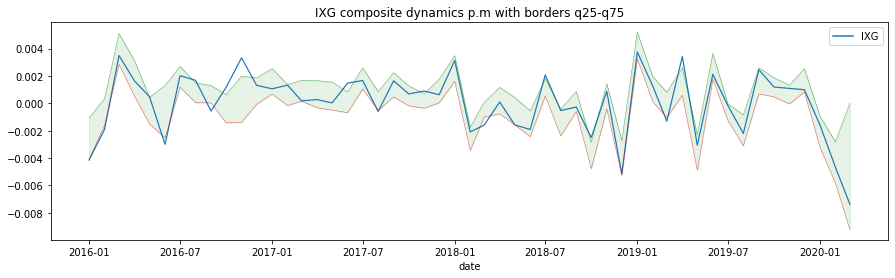

 monthly price margin dynamics for AOA
----------------------------------------------------------------------------------------------------


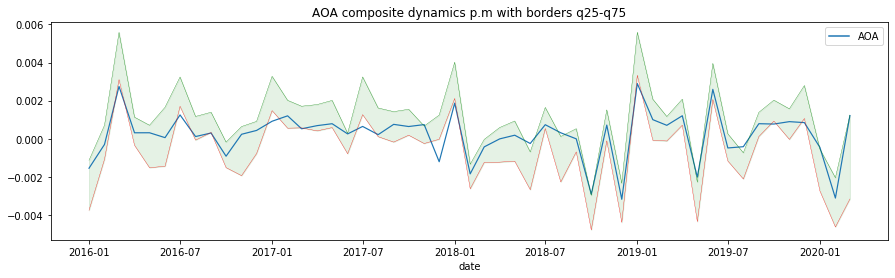

 monthly price margin dynamics for CWI
----------------------------------------------------------------------------------------------------


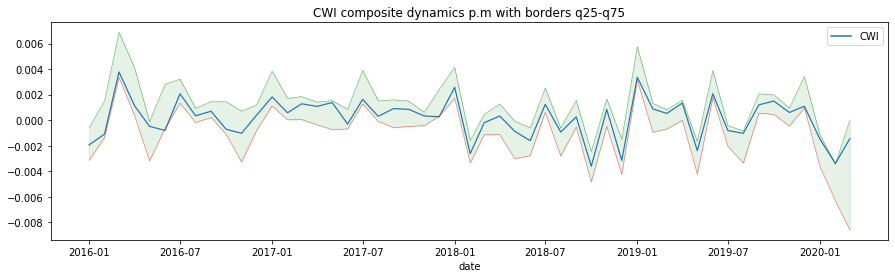

 monthly price margin dynamics for FXZ
----------------------------------------------------------------------------------------------------


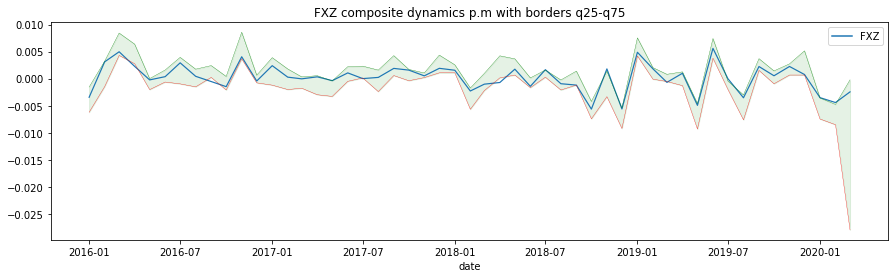

 monthly price margin dynamics for PID
----------------------------------------------------------------------------------------------------


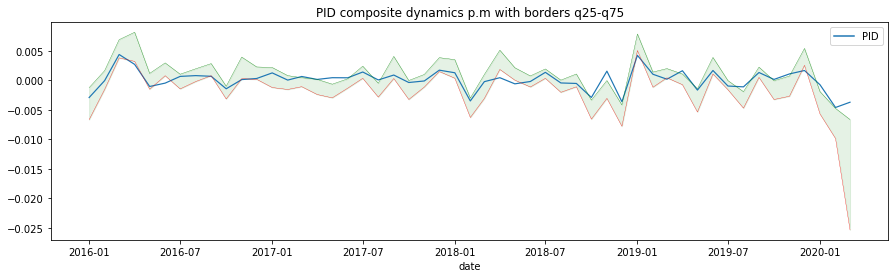

 monthly price margin dynamics for FXL
----------------------------------------------------------------------------------------------------


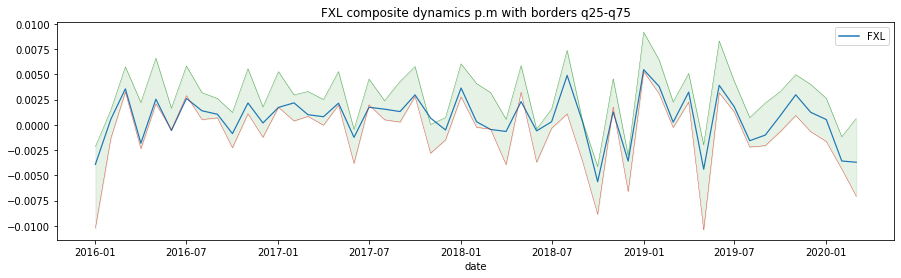

 monthly price margin dynamics for FDM
----------------------------------------------------------------------------------------------------


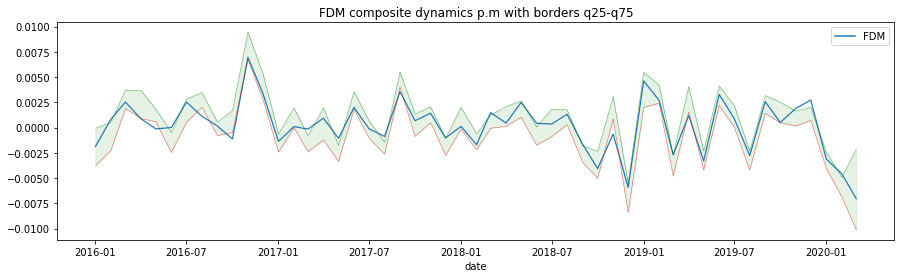

 monthly price margin dynamics for EET
----------------------------------------------------------------------------------------------------


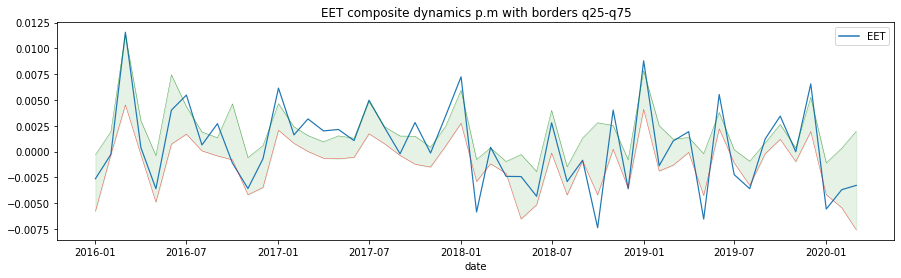

In [26]:
# 5.10. Visual analysis
for cluster_center in df_profiles_clustered_collection.keys():
    print(f' monthly price margin dynamics for {cluster_center}')
    print(100*'-')
    show_groups_dynamics_single_df(df_profiles_clustered_collection, cluster_center, df_prices_pct_centers,
                                   period='MS',  borders='q25-q75')

- As can be seen from the results above, the correlation clustering gives a moderate quality of the centre's proximity to related companies. This is probably due to the fact that a relatively low value (0.65) was chosen as the threshold for the correlation coefficient. The degree of closeness also decreases for larger clusters.  

- However, I believe that this approach is quite competitive with the variants of generation of composite indexes by groups, in contrast to them, it does not use synthetic averaging as a composite, but selects a specific company.

- This approach may be useful for a relatively small sample of companies, where it is also possible to select the optimal threshold correlation value.

- For the next steps of the Project (creating predictive models), will be used as an averaged composite indexes created by sectors, and the centers of the above clusters, so the total number of trained time series will be 26.

### Data Export

In [27]:
# 6.1. Export
# this part commented for secure purposes

#sector_composites = cluster_per_sector.df_composites 
#cluster_composites = df_prices_pct_centers  
#sector_test_comps = cluster_per_sector.df_coll 
#cluster_test_comps = df_profiles_clustered_collection

#with open('datasets_4_modelling/sector_composites.csv', 'w', encoding='utf-8') as f:
#    sector_composites.to_csv(f, encoding='utf-8', columns=sector_composites.columns)

#with open('datasets_4_modelling/cluster_composites.csv', 'w', encoding='utf-8') as f:
#    cluster_composites.to_csv(f, encoding='utf-8', columns=cluster_composites.columns)
    
#with open('datasets_4_modelling/sector_test_comps.pkl', 'wb') as f:
#    pickle.dump(sector_test_comps, f)
    
#with open('datasets_4_modelling/cluster_test_comps.pkl', 'wb') as f:
#    pickle.dump(cluster_test_comps, f)